In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input, Reshape
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
!pip install numpy requests nlpaug
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as nlpaw
from tqdm import tqdm

     |████████████████████████████████| 405 kB 890 kB/s eta 0:00:01


In [3]:
def dataframe_creation():
    col_list=['Loc','Pred','Sent','Topic','Speaker','Position','Region','Party','a','b','c','d','e','Occasion']
    df_4 = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/train.tsv',header = None,sep='\t')
    df_4.columns =  col_list
    return df_4

df = dataframe_creation()
print(df.shape)
le = preprocessing.LabelEncoder()
df.head()

(10240, 14)


,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [4]:
df.columns

Index(['Loc', 'Pred', 'Sent', 'Topic', 'Speaker', 'Position', 'Region',
       'Party', 'a', 'b', 'c', 'd', 'e', 'Occasion'],
      dtype='object')

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X = df['Sent']
Y = df['Pred']
def maxlength(lt):
    maxi = 0
    for i in lt:
        maxi  = max(maxi, len(str(i).split()) )
    return maxi
max_len= maxlength(X)
max_len

467

In [8]:
df['Pred'].value_counts(normalize = True)

half-true      0.206445
false          0.194824
mostly-true    0.191602
true           0.163672
barely-true    0.161523
pants-fire     0.081934
Name: Pred, dtype: float64

<AxesSubplot:>

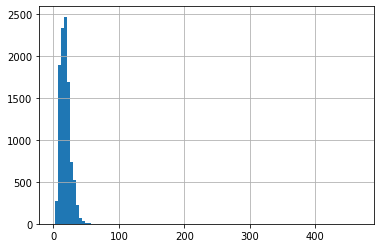

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['Sent']]
pd.Series(seq_len).hist(bins = 100)

In [12]:
sr = pd.Series(seq_len)
print(sr.mean())
print(sr.std())

18.01005859375
9.658571990126005


In [14]:
X = df['Sent']
Y = df['Pred']
max_len= 27
le.fit(Y)
Y = le.transform(Y)
num_classes=  len(le.classes_)

In [15]:
def Convert(lst):
    res_dct = {i : lst[i] for i in range(0, len(lst))}
    return res_dct
classes = Convert(le.classes_)

# Transfer Learning

In [16]:
from tqdm.notebook import tqdm
from transformers import BertTokenizer, TFBertModel, TFDistilBertModel,DistilBertTokenizer , RobertaTokenizer, TFRobertaModel
#dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
#robert_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#robert_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
def data_creation(X,Y,token):
    input_ids=[]
    attention_masks=[]
    for sent in tqdm(X):
        dbert_inps=token.encode_plus(str(sent),add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
        input_ids.append(dbert_inps['input_ids'])
        attention_masks.append(dbert_inps['attention_mask'])

    input_ids=np.asarray(input_ids)
    attention_masks=np.array(attention_masks)
    Y=np.array(Y)
    print(len(input_ids),len(attention_masks),len(Y))
    return input_ids,attention_masks,Y

In [18]:
model_use = bert_model
token_use = bert_tokenizer
input_ids,attention_masks,Y = data_creation(X,Y,token_use)

  0%|          | 0/10240 [00:00<?, ?it/s]

10240 10240 10240


In [19]:
from tensorflow.keras.layers import LSTM,add
from tensorflow.keras.layers import Flatten , Conv1D
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
def create_model(max_len,num_classes,mod):
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = mod(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(4096,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dense = Reshape(( 256 , 16))(dense)
    head4 = Conv1D(36,5)(dense)
    head4 = MaxPooling1D(5,padding='same')(head4)
    head4 = Flatten()(head4)
    dropout= Dropout(0.5)(head4)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    return model

In [20]:
model = create_model(max_len,num_classes,model_use)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_bert_model[0][0]          

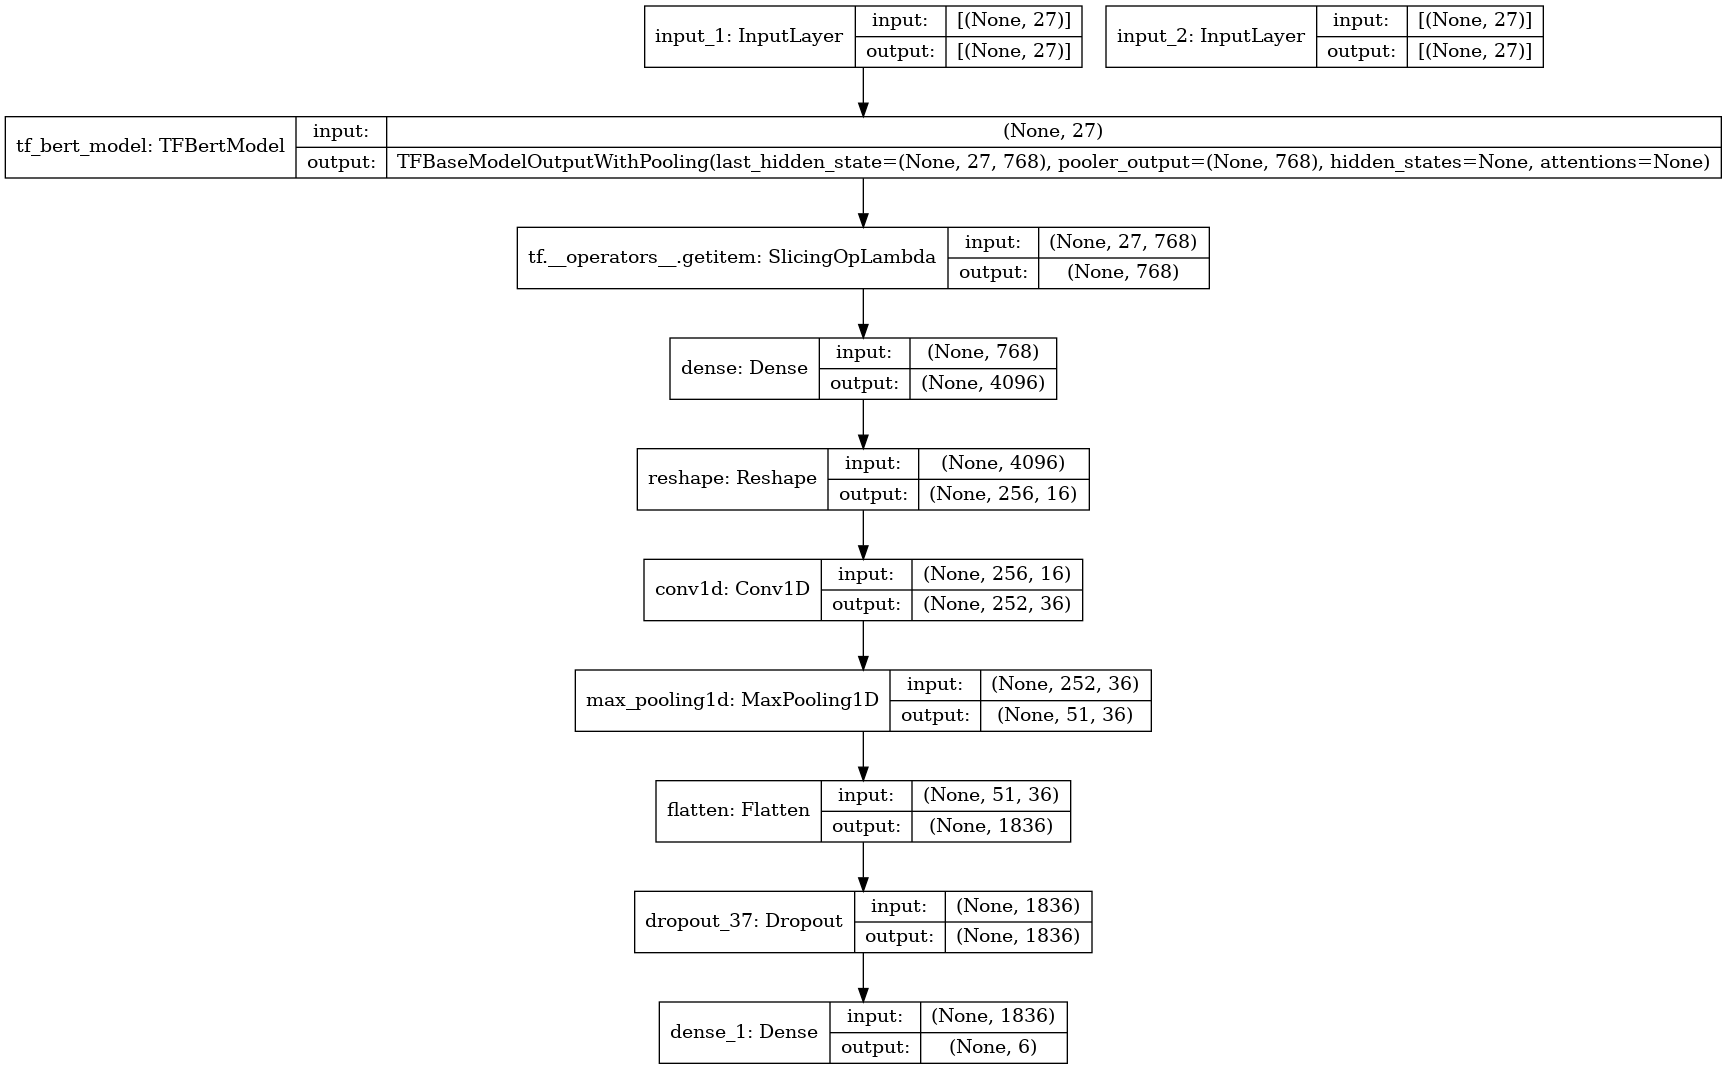

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [22]:
print('Preparing the pickle file.....')

pickle_inp_path='dbert_inp.pkl'
pickle_mask_path='dbert_mask.pkl'
pickle_Pred_path='dbert_Pred.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((Y),open(pickle_Pred_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_Pred_path)

Preparing the pickle file.....
Pickle files saved as  dbert_inp.pkl dbert_mask.pkl dbert_Pred.pkl


In [23]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
Preds=pickle.load(open(pickle_Pred_path, 'rb'))

print('Input shape {} Attention mask shape {} Input Pred shape {}'.format(input_ids.shape,attention_masks.shape,Preds.shape))

Loading the saved pickle files..
Input shape (10240, 27) Attention mask shape (10240, 27) Input Pred shape (10240,)


In [24]:
Pred_class_dict=classes
target_names=Pred_class_dict.values()

In [25]:
train_inp,val_inp,train_Pred,val_Pred,train_mask,val_mask=train_test_split(input_ids,Preds,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain Pred shape {} Val Pred shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_Pred.shape,val_Pred.shape,train_mask.shape,val_mask.shape))


log_dir='dbert_model'
model_save_path='./dbert_model.h5'

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (8192, 27) Val input shape (2048, 27)
Train Pred shape (8192,) Val Pred shape (2048,)
Train attention mask shape (8192, 27) Val attention mask shape (2048, 27)


In [26]:
history=model.fit([train_inp,train_mask],Preds,batch_size=64,epochs=10,validation_data=([val_inp,val_mask],val_Pred))

Epoch 1/10
160/160 [==============================] - 62s 357ms/step - loss: 13.9787 - accuracy: 0.2067 - val_loss: 11.5481 - val_accuracy: 0.2773
Epoch 2/10
160/160 [==============================] - 57s 355ms/step - loss: 10.9086 - accuracy: 0.2645 - val_loss: 9.0477 - val_accuracy: 0.3462
Epoch 3/10
160/160 [==============================] - 57s 354ms/step - loss: 8.5754 - accuracy: 0.3246 - val_loss: 7.0588 - val_accuracy: 0.4849
Epoch 4/10
160/160 [==============================] - 57s 354ms/step - loss: 6.7508 - accuracy: 0.4317 - val_loss: 5.4192 - val_accuracy: 0.6494
Epoch 5/10
160/160 [==============================] - 57s 357ms/step - loss: 5.2608 - accuracy: 0.6038 - val_loss: 4.1308 - val_accuracy: 0.8340
Epoch 6/10
160/160 [==============================] - 56s 353ms/step - loss: 4.0553 - accuracy: 0.7537 - val_loss: 3.1528 - val_accuracy: 0.8970
Epoch 7/10
160/160 [==============================] - 56s 348ms/step - loss: 3.1191 - accuracy: 0.8523 - val_loss: 2.4393 - val

## Evaluation

In [27]:
preds = model.predict([val_inp,val_mask],batch_size=64)
pred_Preds = preds.argmax(axis=1)
target_names=le.classes_
print('Classification Report')
print(classification_report(val_Pred,pred_Preds,target_names=target_names))
print('Training and saving built model.....')

Classification Report
              precision    recall  f1-score   support

 barely-true       0.97      0.98      0.98       321
       false       0.99      0.99      0.99       370
   half-true       0.99      0.98      0.99       455
 mostly-true       1.00      0.98      0.99       392
  pants-fire       0.95      0.99      0.97       169
        true       0.98      0.99      0.99       341

    accuracy                           0.99      2048
   macro avg       0.98      0.99      0.98      2048
weighted avg       0.99      0.99      0.99      2048

Training and saving built model.....


# Create Test from test data and remove non corpus words

In [28]:
col_list=['Loc','Pred','Sent','Topic','Speaker','Position','Region','Party','a','b','c','d','e','Occasion']
dfT = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/test.tsv',header = None,sep='\t')
dfT.columns =  col_list
print(dfT.shape)
dfT.head()

(1267, 14)


,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [29]:
Xt = dfT['Sent']
Yt = dfT['Pred']
Yt = le.transform(Yt)

<AxesSubplot:>

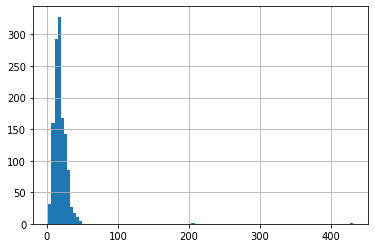

In [32]:
seq_len = [len(i.split()) for i in dfT['Sent']]
pd.Series(seq_len).hist(bins = 100)

In [33]:
sr = pd.Series(seq_len)
print(sr.mean())
print(sr.std())

18.40410418310971
14.892534964751322


In [34]:
input_idsT,attention_masksT,YT = data_creation(Xt,Yt,token_use)

  0%|          | 0/1267 [00:00<?, ?it/s]

1267 1267 1267


In [35]:
preds = model.predict([input_idsT,attention_masksT],batch_size=16)
pred_Preds = preds.argmax(axis=1)
target_names=le.classes_
print('Classification Report')
print(classification_report(Yt,pred_Preds,target_names=target_names))
print('Training and saving built model.....')

Classification Report
              precision    recall  f1-score   support

 barely-true       0.25      0.30      0.27       212
       false       0.27      0.29      0.28       249
   half-true       0.27      0.24      0.26       265
 mostly-true       0.26      0.29      0.27       241
  pants-fire       0.31      0.15      0.20        92
        true       0.26      0.23      0.24       208

    accuracy                           0.26      1267
   macro avg       0.27      0.25      0.25      1267
weighted avg       0.27      0.26      0.26      1267

Training and saving built model.....
